# Tarea 2- Modulo 4

*Agrupar por sector (limpiar los datos)-promedio aritmetico

*Entrenar una regresión Logística y encontrar los mejores hiperparámetros (c, iteraciones, grado de pólinomio, ridge)

*Probar cross-validation

*Graficar Precision-Recall curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (10, 4)

In [3]:
#abrir archivo ipc
ipc_path = "../Tarea/ipc.xlsx" 
market = pd.read_excel(ipc_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "").replace("*", "") for c in market.columns]
market_t=market.T
market_t.index

Index(['KIMBERA', 'GAPB', 'CEMEXCPO', 'ASURB', 'GFNORTEO', 'KOFUBL', 'AC',
       'LABB', 'FEMSAUBD', 'OMAB', 'GFINBURO', 'AMXL', 'ALSEA', 'ORBIA',
       'PE&OLES', 'GRUMAB', 'RA', 'WALMEX', 'BOLSAA', 'LIVEPOLC', 'GENTERA',
       'IENOVA', 'CUERVO', 'ELEKTRA', 'BBAJIOO', 'ALPEKA', 'MEGACPO', 'GCC',
       'BIMBOA', 'GMEXICOB', 'GCARSOA1', 'TLEVICPO', 'ALFAA', 'BSMXB',
       'PINFRA', 'MEXBOL'],
      dtype='object')

In [4]:
#abrir archivo emisoras
bmv_emisora = "../Tarea/bmv_emisoras.csv" 
emisoras = pd.read_csv(bmv_emisora, index_col=0)
emisoras.index

Index(['AC', 'ACCELSA', 'ACTINVR', 'AEROMEX', 'AGRIEXP', 'AGUA', 'AHMSA',
       'ALEATIC', 'ALFA', 'ALPEK',
       ...
       'UNIFIN', 'URBI', 'VALUEGF', 'VASCONI', 'VESTA', 'VINTE', 'VISTA',
       'VITRO', 'VOLAR', 'WALMEX'],
      dtype='object', name='key', length=139)

In [5]:
#Relacionar los indices de market_t y emisoras, ya que algunos valores no coinciden por completo. 
#Se calcula un ratio de coincidencias arriba del 70 porciento 

data_dict1 = {"nombre_market":[],"nombre_emisoras":[],"ratio":[]}
for x in market_t.index:
    for y in emisoras.index:
        ratio = SequenceMatcher(None, y, x[:-1]).ratio() 
        data_dict1["nombre_market"].append(x)
        data_dict1["nombre_emisoras"].append(y)
        data_dict1["ratio"].append(ratio)


df_ratio1 = pd.DataFrame(data_dict1)

coin_2=df_ratio1[df_ratio1["ratio"] > 0.70]



In [6]:
#Se calcula un ratio de coincidencias arriba del 80 porciento 

data_dict = {"nombre_market":[],"nombre_emisoras":[],"ratio":[]}
for x in market_t.index:
    for y in emisoras.index:
        ratio = SequenceMatcher(None, y, x).ratio() 
        data_dict["nombre_market"].append(x)
        data_dict["nombre_emisoras"].append(y)
        data_dict["ratio"].append(ratio)

df_ratio = pd.DataFrame(data_dict)

coin_1=df_ratio[df_ratio["ratio"] > 0.80]


In [7]:
#agrupamos la información optenida de coin_1 y coin_2 y quitamos duplicados para nombre_market
coin=pd.concat([coin_1, coin_2], ignore_index=True)
coin=coin.drop_duplicates(['nombre_market'], keep='first')

#relacionamos la información de coin con emisoras para traer el Sector
coin_s = pd.merge(left=coin, right=emisoras, left_on='nombre_emisoras', right_on='key')

#solo mostramos las tres columnas deseadas
sector=coin_s[['nombre_market','nombre_emisoras','Sector']]

sector.head()


,nombre_market,nombre_emisoras,Sector
0,KIMBERA,KIMBER,PRODUCTOS DE CONSUMO FRECUENTE
1,GAPB,GAP,INDUSTRIAL
2,ASURB,ASUR,INDUSTRIAL
3,GFNORTEO,GFNORTE,SERVICIOS FINANCIEROS
4,AC,AC,PRODUCTOS DE CONSUMO FRECUENTE


In [8]:
#relacionamos la información de market_t y sector
sector_f = pd.merge(left=market_t,right=sector, left_on=market_t.index, right_on='nombre_market')
#aplicamos doble indice 
sector_f.set_index(['Sector','nombre_market'],inplace=True)
sector_f.head()

,,2016-01-01 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,...,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,nombre_emisoras
Sector,nombre_market,,,,,,,,,,,,,,,,,,,,,
PRODUCTOS DE CONSUMO FRECUENTE,KIMBERA,40.37,39.16,38.89,39.13,39.16,38.65,37.85,39.08,39.95,39.54,...,38.83,38.83,39.02,38.77,38.50,37.50,37.50,38.09,38.07,KIMBER
INDUSTRIAL,GAPB,152.05,148.57,147.93,146.99,141.32,143.74,144.94,144.16,146.70,145.85,...,226.99,226.99,227.65,226.86,225.87,224.67,224.67,227.63,228.84,GAP
MATERIALES,CEMEXCPO,8.72,8.43,8.31,8.29,7.64,7.18,7.24,7.39,7.14,7.36,...,7.23,7.23,7.33,7.23,7.16,7.08,7.08,7.16,7.19,CEMEX
INDUSTRIAL,ASURB,243.89,238.29,233.03,231.97,230.71,229.76,227.83,231.81,226.71,225.29,...,353.16,353.16,357.94,356.15,354.06,354.04,354.04,360.48,362.25,ASUR
SERVICIOS FINANCIEROS,GFNORTEO,94.99,91.79,91.72,91.63,89.54,88.85,89.30,89.34,88.62,87.59,...,110.20,110.20,109.63,108.92,105.00,105.65,105.65,109.66,109.96,GFNORTE


In [9]:
#agrupamos por Sector y calculamos su media
sector_f = sector_f.groupby(level="Sector").mean()
sector_mean= sector_f.T
sector_mean.head()

Sector,ENERGÍA,INDUSTRIAL,MATERIALES,PRODUCTOS DE CONSUMO FRECUENTE,SALUD,SERVICIOS DE TELECOMUNICACIONES,SERVICIOS FINANCIEROS,SERVICIOS Y BIENES DE CONSUMO NO BÁSICO
2016-01-01 00:00:00,72.34,117.845714,58.346,108.824286,13.85,56.883333,50.148333,216.333333
2016-01-04 00:00:00,72.98,116.128571,57.482,106.207143,14.41,56.366667,49.115000,212.393333
2016-01-05 00:00:00,71.48,115.488571,57.648,105.451429,13.77,55.673333,48.971667,209.043333
2016-01-06 00:00:00,70.94,114.577143,56.514,107.150000,13.65,55.140000,48.645000,202.943333
2016-01-07 00:00:00,72.31,112.128571,56.122,106.498571,13.25,54.783333,47.453333,200.226667


In [10]:
#calculamos la media por cada fecha
sector_mean['mean_s'] = sector_mean.mean(axis=1)
sector_mean.head()

Sector,ENERGÍA,INDUSTRIAL,MATERIALES,PRODUCTOS DE CONSUMO FRECUENTE,SALUD,SERVICIOS DE TELECOMUNICACIONES,SERVICIOS FINANCIEROS,SERVICIOS Y BIENES DE CONSUMO NO BÁSICO,mean_s
2016-01-01 00:00:00,72.34,117.845714,58.346,108.824286,13.85,56.883333,50.148333,216.333333,86.821375
2016-01-04 00:00:00,72.98,116.128571,57.482,106.207143,14.41,56.366667,49.115000,212.393333,85.635339
2016-01-05 00:00:00,71.48,115.488571,57.648,105.451429,13.77,55.673333,48.971667,209.043333,84.690792
2016-01-06 00:00:00,70.94,114.577143,56.514,107.150000,13.65,55.140000,48.645000,202.943333,83.694935
2016-01-07 00:00:00,72.31,112.128571,56.122,106.498571,13.25,54.783333,47.453333,200.226667,82.846560


In [11]:
# Limpiando información
y = (sector_mean["mean_s"].diff().shift(-1) > 0) *1.0
X = sector_mean.drop("mean_s", axis=1).join(y, how="inner")

y = X["mean_s"]
X = X.drop("mean_s", axis=1)

In [12]:
#se generan los train y el test
train_period = "2019-10"
test_period = "2019-11-20"
Xtrain, ytrain = X[:train_period], y[:train_period]
Xtest, ytest = X[:test_period], y[:test_period]

In [13]:
y.value_counts()

0.0    525
1.0    521
Name: mean_s, dtype: int64

In [14]:
# Crea la regresión logistica
logistic = LogisticRegression(solver='lbfgs',max_iter=700)
# se crea el espacio de penalización 
penalty = ['l2']

# Se crea la regularización del espacio del hiperparametro
C = np.logspace(0, 4, 200)

# Crear opciones de hiperparámetro
hyperparameters = dict(C=C, penalty=penalty)

# Crea una búsqueda de cuadrícula utilizando la validación cruzada de 5
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Ajustamos la busqueda
best_model = clf.fit(Xtrain, ytrain)


In [15]:
# Ver los mejores hiperparámetros

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 943.7878277775382


In [16]:
#best_model

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=700, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.000000...
       4.15040476e+03, 4.34701316e+03, 4.55293507e+03, 4.76861170e+03,
       4.99450512e+03, 5.23109931e+03, 5.47890118e+03, 5.73844165e+03,
       6.01027678e+03, 6.29498899e+03, 6.59318827e+03, 6.90551352e+03,
       7.23263390e+03, 7.57525026e+03, 7.93409667e+03, 8.30994195e+03,
       8.

In [17]:
#se genera el modelo predictivo
yhat = best_model.predict(Xtest)

In [18]:
#se genera la matriz de confusión
confusion_matrix(ytest, yhat, labels=[0, 1])

array([[300, 206],
       [282, 226]], dtype=int64)

In [19]:
#se calcula la precision
precision_score(ytest, yhat)

0.5231481481481481

In [20]:
#se calcula el recall
recall_score(ytest, yhat)

0.4448818897637795

In [21]:
#se calcula el F1
f1_score(ytest, yhat)

0.4808510638297872

Text(0.5, 0, 'Nivel de proba asignada')

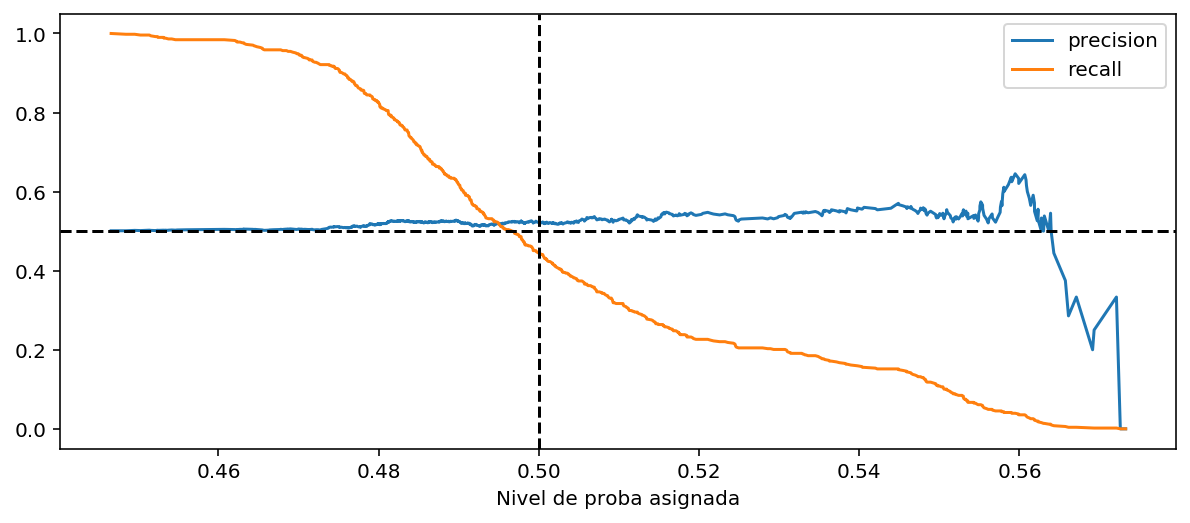

In [22]:
#se grafica la precision_recall_curve
proba_estimate = best_model.predict_proba(Xtest)[:, 1]
prec, recall, threshold = precision_recall_curve(ytest, proba_estimate)

plt.plot(threshold, prec[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()
plt.axvline(x=0.5, linestyle="--", c="black")
plt.axhline(y=0.5, linestyle="--", c="black")
plt.xlabel("Nivel de proba asignada")